# Case study: Salary vs Education

__How the salary and job position are affected by the education level?__

---

We are given a relation of workers' salaries and their experience level, education grade and whether they hold a management position or not. 

Our goal is to: 
* Predict the salary
* Predict whether a worker holds a _management_ position.

For this, we are going to apply linear and logistic regression models and obtain their performance using several evaluation metrics. Furthermore, we answer the main cuestion by investigating the dependence of the target variable on the features using [partial-dependence plots](https://www.kaggle.com/dansbecker/partial-dependence-plots).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import mean_squared_error as mse, r2_score, roc_curve, confusion_matrix, classification_report, roc_auc_score
#
sns.set(font_scale=1.5)
#sns.set_style("whitegrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)
#
warnings.filterwarnings('ignore')

We start by loading the data and explore its info and statistics. We see that it comes with four features (two numerical columns, one of string type and one of boolean type.) No null entries exist.

In [2]:
data = pd.read_csv('salary.csv')
data.head(10)

,Salary,Experience,Education,Management
0,13876,1,Bachelor,True
1,11608,1,PhD,False
2,18701,1,PhD,True
3,11283,1,Master,False
4,11767,1,PhD,False
5,20872,2,Master,True
6,11772,2,Master,False
7,10535,2,Bachelor,False
8,12195,2,PhD,False
9,12313,3,Master,False


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
Salary        46 non-null int64
Experience    46 non-null int64
Education     46 non-null object
Management    46 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 1.2+ KB


In [4]:
data.describe()

,Salary,Experience
count,46.000000,46.000000
mean,17270.195652,7.500000
std,4716.631513,5.171503
min,10535.000000,1.000000
25%,13320.750000,3.000000
50%,16436.000000,6.000000
75%,20719.750000,11.000000
max,27837.000000,20.000000


## Exploratory Data Analysis
---
We perform an EDA of the variables in the dataset. First, we explore the relation between _Salary_ and _Education_ and then the relation between _Salary_ and _Experience_.

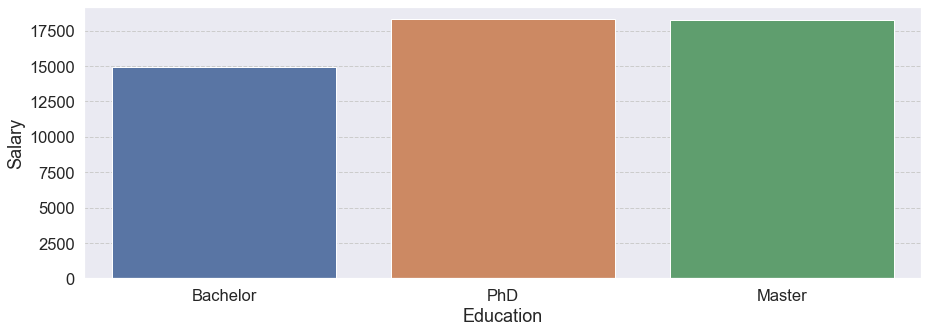

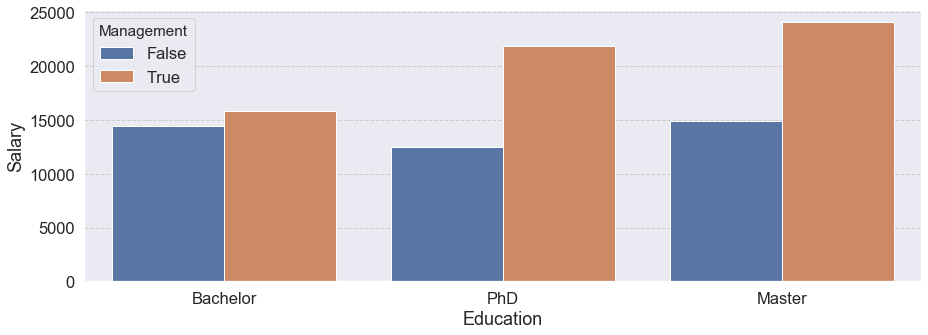

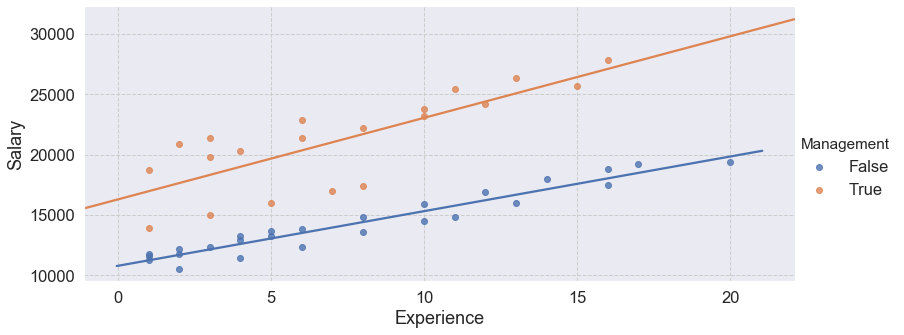

In [5]:
plt.figure(figsize=(15,5))
sns.barplot(x='Education', y='Salary', data=data, ci=None)
plt.figure(figsize=(15,5))
sns.barplot(x='Education', y='Salary', hue='Management', data=data, ci=None)
sns.lmplot(x='Experience', y='Salary', hue='Management', data=data, ci=None, height=5, aspect=2.3)
plt.show()

We clearly see that there is a correlation in _Salary_ and whether a person has undergraduate or graduate study levels. However the correlation does not hold when we separate the cases with respect to the _Management_ variable as clearly the PhD salaries decrease. On the other hand, the correlation clearly holds with respect to _Experience_, independently of the _Management_ variable. 

To see it more clearly, we plot a correlation matrix after categorically splitting the _Education_ variable. For this, we use the ```pd.get_dummies``` function, where the categories are transform as binary columns in which a value of 1 corresponds to the existence of the category in the sample. We also drop one of the columns as only $k-1$ variables (where $k$ is the number of categories) are linearly independent.

In [6]:
# Transform categorical data (Education)
data = pd.get_dummies(data, drop_first=True)

# Correlation matrix
corr = pd.DataFrame(data).corr()
corr

,Salary,Experience,Management,Education_Master,Education_PhD
Salary,1.000000,0.538886,0.729525,0.182727,0.137589
Experience,0.538886,1.000000,-0.051441,0.142423,-0.240695
Management,0.729525,-0.051441,1.000000,-0.112297,0.228662
Education_Master,0.182727,0.142423,-0.112297,1.000000,-0.526514
Education_PhD,0.137589,-0.240695,0.228662,-0.526514,1.000000


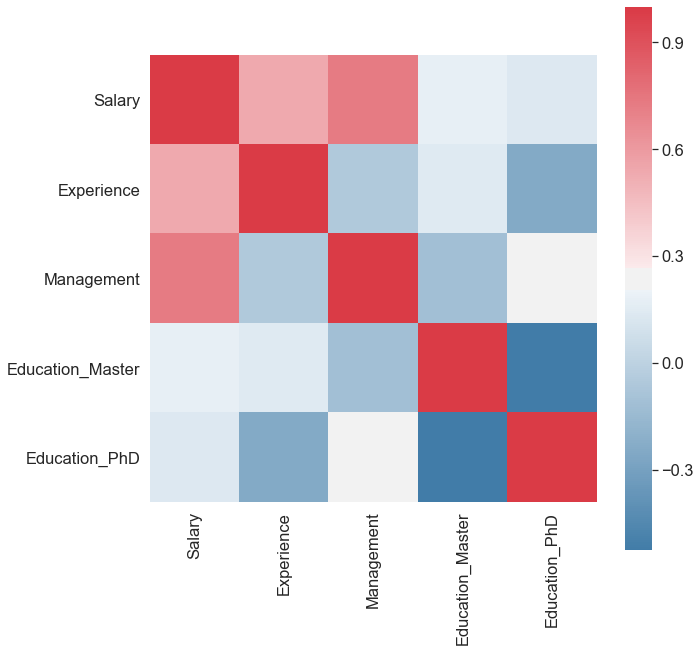

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(240, 10, as_cmap=True), square=True, ax=ax)
plt.show()

We again notice that the _Salary_ is more influenced by the _Experience_ and _Management_ variables than the _Education_ one. However, a Master's appears to have more effect than PhD -- as we found before. 

On the other hand, the _Management_ variable is by far more affected by the _Salary_, followed by a PhD education level.

## Predicting
---

___How much a a worker earns?___  

We construct a simple __linear regressor__ using ```LinearRegression()``` from ```sklearn.linear_model```. As test metrics, we will apply the root mean squared error and the coefficient of determination $R^2$ (score.)

In [8]:
seed = 123
X = data.drop(['Salary'], axis=1)  # Features
y = data['Salary']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_error = mse(y_test, y_pred)**(1/2)
lr_accuracy = r2_score(y_test, y_pred)

print('Test set RMSE of linear regressor: {:.2f}'.format(lr_error))
print('Test set score of linear regressor: {:.4f}'.format(lr_accuracy))

Test set RMSE of linear regressor: 1127.19
Test set score of linear regressor: 0.9434


The simple Linear Regressor performs fairly well, with a score of 94.34% when applied on the test set. 

One important tool to understand how each of the variables affects the performance of the model is the __partial-dependence plots__. In these plots, if there is more variation for any given feature, it means the value of that variable affects the model quite a lot; but if the line is constant near zero it shows that the variable has no effect on the model. On the y-axis, having a negative value means that for that particular value of the feature, it is less likely to predict the correct class on that observation and having a positive value means it has positive impact on predicting the correct class.

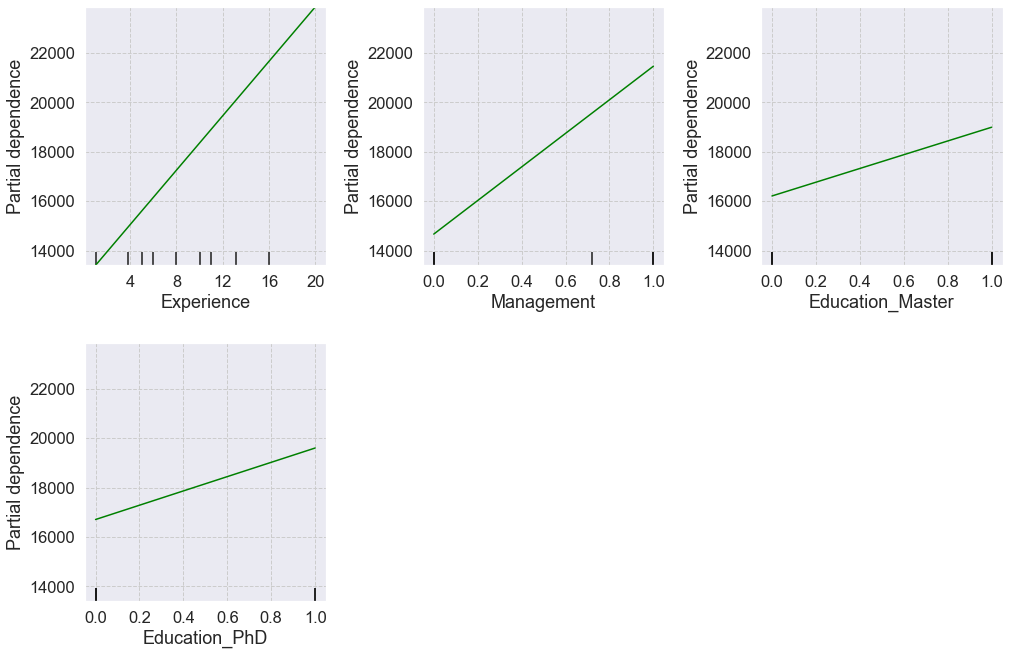

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_partial_dependence(lr, features=[0, 1, 2, 3], X=X_train, feature_names=X.columns, fig=fig)

We clearly see that there exist linear relationships between _Salary_ and the rest of variables but _Experience_ and _Management_ influence more greatly than the others.

---
___Is the worker a manager?___

We now want to see how the _Salary_, _Education_ and _Experience_ affect whether a person has a _Management_ position or not. 

This is a classification problem. Therefore, we construct a logistic regression model and, accordingly, our test metrics will include the __confussion matrix__ and the Receiver Operating Characteristic (__ROC__) curve (a plot of the true positive rate against the false positive rate) for which we compute the __area under the curve__, metric which tells us how good our model is in general.

Confusion matrix:
[[4 3]
 [1 6]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.67      0.86      0.75         7

    accuracy                           0.71        14
   macro avg       0.73      0.71      0.71        14
weighted avg       0.73      0.71      0.71        14


Model score (area under the ROC curve):
0.9183673469387754


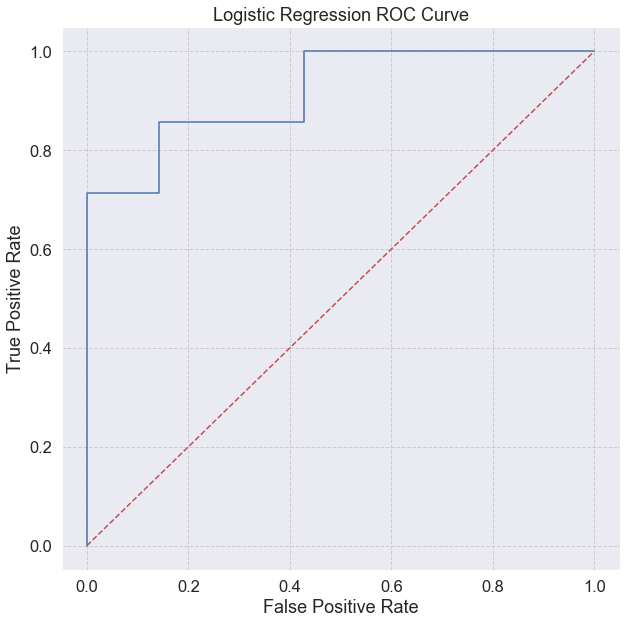

In [10]:
# Transform Boolean to categorical
data['Management'] = data['Management'].astype('category')
data['Management'] = data['Management'].cat.codes

X = data.drop(['Management'], axis=1)  # Features
y = data['Management']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

logreg_error = mse(y_test, y_pred)**(1/2)
logreg_accuracy = r2_score(y_test, y_pred)

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred))

# Plot ROC curve
plt.figure(figsize=(10, 10))
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

print('\nModel score (area under the ROC curve):')
print(roc_auc_score(y_test, y_pred_prob))

We can see that for the small test set, the logistic regressor has an averaged precision of 85% (correct predictions,) a f-1 score of 79% (correct positive predictions) and, in general, a model score of 91.8% (area under the ROC curve.) 

As for the feature importances, we show the partial-dependence plots for our logistic regressor model.

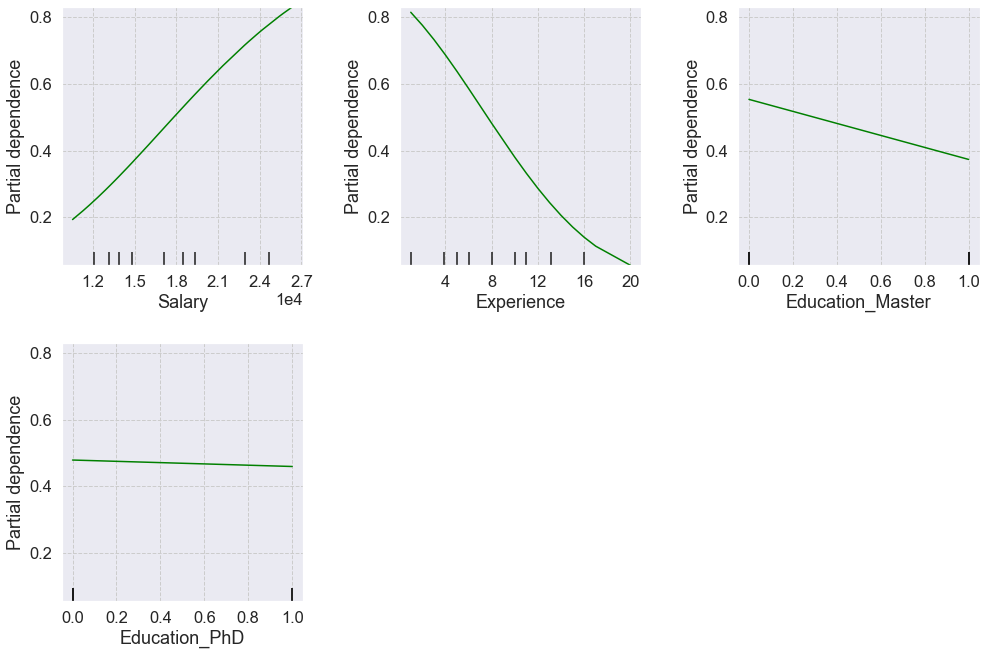

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_partial_dependence(logreg, features=[0, 1, 2, 3], X=X_train, feature_names=X.columns, 
                        fig=fig)

As previously, we see the linear relationship of _Salary_ and _Management_ whereas we now notice the inverse relationship of _Managemente_ and _Experience_: as _Experience_ increases it is more probable to predict a non management position. On the other hand, the _Education_ variables do not affect greatly the target variable and thus we could drop them from the analysis--this would not affect the model score. 